In [0]:
from pyspark.sql import SparkSession

# Initialize Spark session (if not already initialized)
spark = SparkSession.builder \
    .appName("Load Delta Table Example") \
    .getOrCreate()

# Define the name of your Delta table
table_name = "tmbdApi_movies_data"  # Use the name of your table

# Load the Delta table into a DataFrame
delta_table_df = spark.read.format("delta").table(table_name)

# Show the contents of the Delta table
print(f"\nContents of the table '{table_name}':")
delta_table_df.show(truncate=False)  # Use truncate=False to see full column values

# Optionally, print the schema of the DataFrame to understand its structure
print("\nSchema of the DataFrame:")
delta_table_df.printSchema()

# Stop the Spark session if no longer needed
# spark.stop()  # Uncomment this line if you want to stop the session after loading



Contents of the table 'tmbdApi_movies_data':
+-----------------+--------------------------------+------------------------+------------+----------------+------------------+-----------+-------------+--------------------+------+----------+-----------+------------------+-----------+
|original_language|title                           |genre                   |release_date|total_vote_count|average_vote_count|movie_count|genre_type   |Performance_Analysis|id    |popularity|genre_count|average_popularity|yoy_growth |
+-----------------+--------------------------------+------------------------+------------+----------------+------------------+-----------+-------------+--------------------+------+----------+-----------+------------------+-----------+
|en               |Fantasia 2000                   |Animation, Family, Music|2000-01-01  |5605743.0       |104.9410872739526 |53418      |multi_genre  |Hit                 |49948 |14.509    |3          |3.986             |Low Growth |
|ko           

Genre counts:
single_genre     48075
multi_genre      35991
unknown_genre    20839
Name: genre_type, dtype: int64


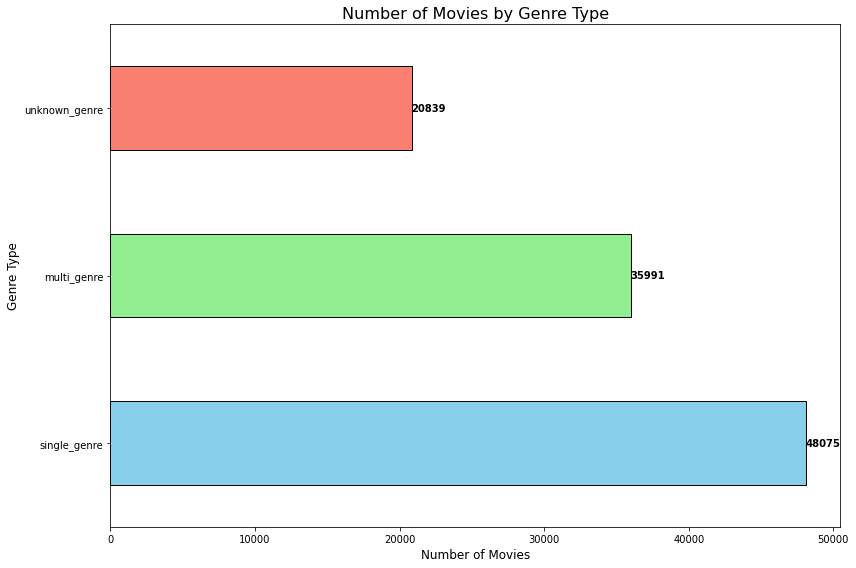

In [0]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming delta_table_df is your Spark DataFrame containing the data
# Convert Spark DataFrame to Pandas DataFrame
pandas_df = delta_table_df.toPandas()

# Ensure 'genre_type' is present and clean
pandas_df['genre_type'] = pandas_df['genre_type'].fillna('Unknown Genre')

# Count the number of movies in each genre type
genre_counts = pandas_df['genre_type'].value_counts()

# Debugging: Print the counts to verify
print("Genre counts:")
print(genre_counts)

# Plotting horizontal bar chart
plt.figure(figsize=(12, 8))  # Increased figure size for better visibility
bars = genre_counts.plot(kind='barh', color=['skyblue', 'lightgreen', 'salmon'], edgecolor='black')

# Adding plot details
plt.title('Number of Movies by Genre Type', fontsize=16)
plt.xlabel('Number of Movies', fontsize=12)
plt.ylabel('Genre Type', fontsize=12)

# Adding count labels on the bars
for i, v in enumerate(genre_counts):
    plt.text(v + 0.5, i, str(v), va='center', fontweight='bold')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()


Found invalid dates in the dataset:
      original_language                          title genre release_date  \
1295                             "The ""Martha"" Tapes     0          NaT   
22924       Documentary  """The Ornithopter Story: Fly     2          NaT   

       total_vote_count  average_vote_count  movie_count    genre_type  \
1295              0.004               0.004            1  single_genre   
22924             0.679               0.679            1  single_genre   

      Performance_Analysis       id  popularity  genre_count  \
1295              Disaster  1394622         0.0            1   
22924                  Hit   708519         6.5            1   

       average_popularity yoy_growth  
1295                1.215       None  
22924               1.215       None  


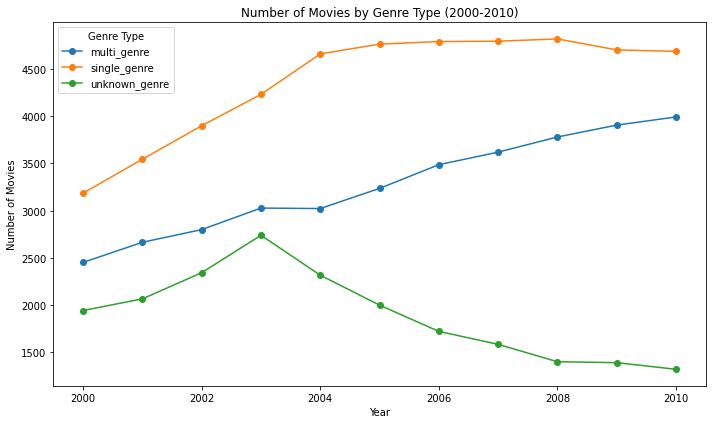

In [0]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming delta_table_df is your Spark DataFrame containing the data
# Convert Spark DataFrame to Pandas DataFrame
pandas_df = delta_table_df.toPandas()

# Attempt to convert 'release_date' to datetime, coerce errors to NaT (Not a Time)
pandas_df['release_date'] = pd.to_datetime(pandas_df['release_date'], errors='coerce')

# Check for rows where release_date could not be converted and set them as NaT
invalid_dates = pandas_df[pandas_df['release_date'].isna()]
if not invalid_dates.empty:
    print("Found invalid dates in the dataset:")
    print(invalid_dates)

# Drop rows with invalid release dates
pandas_df = pandas_df.dropna(subset=['release_date'])

# Extract the release year from the release_date
pandas_df['release_year'] = pandas_df['release_date'].dt.year

# Filter the data for years 2000 to 2010
filtered_df = pandas_df[(pandas_df['release_year'] >= 2000) & (pandas_df['release_year'] <= 2010)]

# Verify 'genre_type' column
if 'genre_type' not in filtered_df.columns:
    raise ValueError("The column 'genre_type' is missing from the DataFrame.")

# Group the data by year and genre_type and count occurrences
genre_counts_by_year = filtered_df.groupby(['release_year', 'genre_type']).size().unstack(fill_value=0)

# Plotting a line chart for each genre type
plt.figure(figsize=(10, 6))

# Plot each genre type as a separate line
for genre in genre_counts_by_year.columns:
    plt.plot(genre_counts_by_year.index, genre_counts_by_year[genre], marker='o', label=genre)

# Adding plot details
plt.title('Number of Movies by Genre Type (2000-2010)')
plt.xlabel('Year')
plt.ylabel('Number of Movies')

# Adding a legend
plt.legend(title='Genre Type')

# Adjusting layout for better readability
plt.tight_layout()

# Display the plot
plt.show()


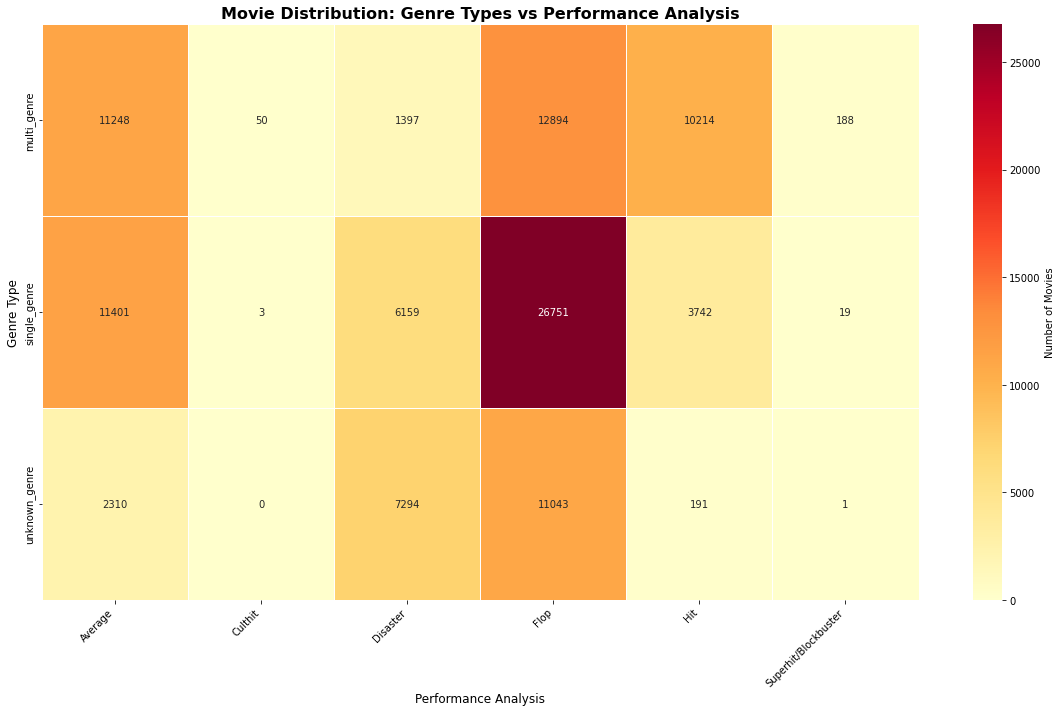

In [0]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Initialize Spark session
spark = SparkSession.builder \
    .appName("Movie Data Analysis") \
    .getOrCreate()

# Load data from the movies_data table and perform aggregation
df = spark.sql("""
    SELECT genre_type, 
           Performance_Analysis, 
           COUNT(*) AS movie_count
    FROM tmbdApi_movies_data
    GROUP BY genre_type, Performance_Analysis
""")

# Convert Spark DataFrame to Pandas DataFrame
pandas_df = df.toPandas()

# Pivot the data for heatmap format
heatmap_data = pandas_df.pivot_table(
    index='genre_type', 
    columns='Performance_Analysis', 
    values='movie_count', 
    fill_value=0
)

# Create the heatmap with enhanced styling using Matplotlib and Seaborn
plt.figure(figsize=(16, 10))  # Set the figure size before plotting

# Create the heatmap using seaborn (which utilizes matplotlib)
sns.heatmap(
    heatmap_data, 
    annot=True,           # Show numerical values
    fmt=".0f",            # Format as whole numbers
    cmap="YlOrRd",       # Choose a color palette (you can change it)
    linewidths=0.5,       # Add lines between cells
    cbar_kws={'label': 'Number of Movies'}  # Colorbar label
)

# Customize the plot using Matplotlib functions
plt.title(
    "Movie Distribution: Genre Types vs Performance Analysis", 
    fontsize=16, 
    fontweight='bold'
)
plt.xlabel("Performance Analysis", fontsize=12)
plt.ylabel("Genre Type", fontsize=12)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Adjust layout to prevent cutting off labels
plt.tight_layout()

# Display the plot using Matplotlib's show function
plt.show()


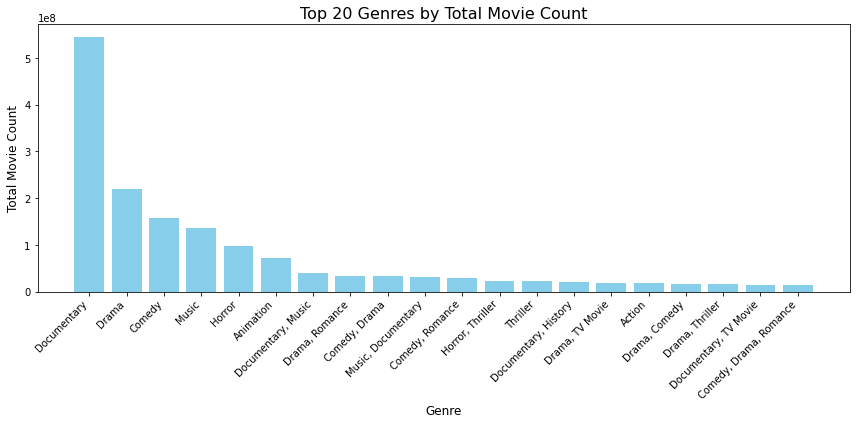

In [0]:
from pyspark.sql import SparkSession
import pandas as pd
import matplotlib.pyplot as plt

# Initialize Spark session
spark = SparkSession.builder \
    .appName("Movie Data Analysis") \
    .getOrCreate()

# Load data from the movies_data table and perform aggregation, excluding 'Unknown' genre
df = spark.sql("""
    SELECT 
        genre,
        SUM(movie_count) AS total_movie_count,
        AVG(average_popularity) AS avg_popularity
    FROM tmbdApi_movies_data
    WHERE genre != 'Unknown genre'  -- Exclude 'Unknown' genre
    GROUP BY genre
    ORDER BY total_movie_count DESC
    LIMIT 20  -- Limiting to top 20 genres for better visibility
""")

# Convert Spark DataFrame to Pandas DataFrame
pandas_df = df.toPandas()

# Check if there are any rows in the DataFrame
if pandas_df.empty:
    print("No data available for plotting.")
else:
    # Create a bar chart for total movie counts by genre
    plt.figure(figsize=(12, 6))
    
    # Plotting the bar chart
    plt.bar(pandas_df['genre'], pandas_df['total_movie_count'], color='skyblue')

    # Adding plot details
    plt.title('Top 20 Genres by Total Movie Count', fontsize=16)
    plt.xlabel('Genre', fontsize=12)
    plt.ylabel('Total Movie Count', fontsize=12)
    
    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45, ha='right')

    # Adjust layout to prevent cutting off labels
    plt.tight_layout()

    # Display the plot
    plt.show()


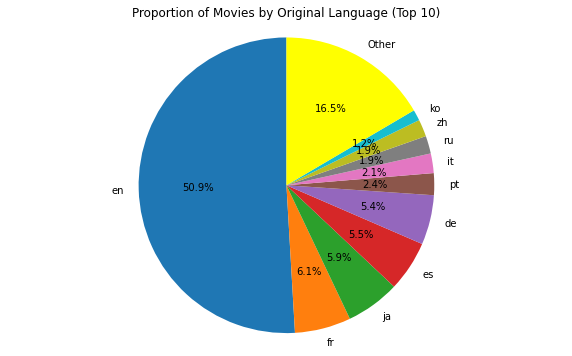

In [0]:
# Import necessary libraries
import matplotlib.pyplot as plt

# Step 1: Convert Spark DataFrame to Pandas DataFrame
pandas_df = delta_table_df.toPandas()

# Step 2: Prepare the data for the pie chart
# Group by 'original_language' and count occurrences
language_counts = pandas_df['original_language'].value_counts()

# Get the top 10 languages
top_languages = language_counts.head(10)

# Include all other languages as 'Other'
other_count = language_counts[10:].sum()
if other_count > 0:
    top_languages['Other'] = other_count

# Step 3: Create a pie chart with custom colors
plt.figure(figsize=(10, 6))

# Define colors: Generate a color palette and add yellow for 'Other'
colors = plt.cm.tab10.colors  # Get a colormap with distinct colors
colors = list(colors)  # Convert to a list for indexing
colors.append('yellow')  # Add yellow for the 'Other' category

# Create pie chart with specified colors
plt.pie(top_languages, labels=top_languages.index, autopct='%1.1f%%', startangle=90, colors=colors)

plt.title('Proportion of Movies by Original Language (Top 10)')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


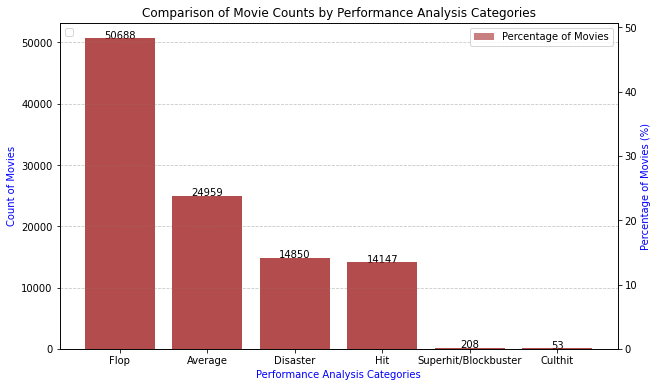

In [0]:
# Import necessary libraries
import matplotlib.pyplot as plt
import pandas as pd

# Step 1: Convert Spark DataFrame to Pandas DataFrame (if not already done)
# pandas_df = delta_table_df.toPandas()  # Uncomment if needed

# Step 2: Prepare the data for the clustered bar chart
# Count occurrences of each performance category
performance_counts = pandas_df['Performance_Analysis'].value_counts()

# Calculate percentages
performance_percentage = (performance_counts / performance_counts.sum()) * 100

# Step 3: Create a clustered bar chart
categories = performance_counts.index
counts = performance_counts.values
percentages = performance_percentage.values

x = range(len(categories))  # x locations for groups

# Create figure and axes
fig, ax1 = plt.subplots(figsize=(10, 6))

# Create bar chart for counts in red
bars1 = ax1.bar(x, counts, color='brown', alpha=0.6)

# Create a second y-axis for percentages in red
ax2 = ax1.twinx()
bars2 = ax2.bar(x, percentages, color='brown', alpha=0.6, label='Percentage of Movies')

# Adding labels and title
ax1.set_xlabel('Performance Analysis Categories', color='blue')
ax1.set_ylabel('Count of Movies', color='blue')
ax2.set_ylabel('Percentage of Movies (%)', color='blue')
ax1.set_title('Comparison of Movie Counts by Performance Analysis Categories')

# Set x-ticks to be the category names
ax1.set_xticks(x)
ax1.set_xticklabels(categories)

# Adding legends
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Show grid for better readability
ax1.grid(axis='y', linestyle='--', alpha=0.7)

# Step 4: Label the movie count on respective bars
for i, count in enumerate(counts):
    ax1.text(i, count + 0.5, str(count), ha='center', color='black')

# Display the plot
plt.show()
